In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('summer_camp_data.csv')
df.head(10)

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0
5,2020-05-11,yandex,cpc,Не определено,Десктоп,no,no,2775,1441,5990,1196,549,76,90862.0
6,2020-05-11,yandex,organic,Не определено,Мобайл,no,no,3116,1395,4950,990,703,112,111012.0
7,2020-05-11,yandex,cpc,Не определено,Мобайл,no,no,3854,1842,7310,1462,913,150,168397.0
8,2020-05-11,yandex,cpc,Не определено,Десктоп,yes,no,2816,510,8450,1688,949,170,187452.0
9,2020-05-11,(direct),(none),Не определено,Десктоп,yes,no,1184,324,2710,542,269,54,67849.0


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pageviews,52721.0,445.620417,1108.398930,0.0,12.0,47.0,256.0,26589.0
visits,52721.0,127.120844,384.872452,1.0,2.0,7.0,41.0,6975.0
productClick,52721.0,890.756245,2100.555207,0.0,20.0,90.0,520.0,32460.0
addToCart,52721.0,177.974659,419.898507,0.0,4.0,18.0,104.0,6486.0
checkout,52721.0,146.557615,344.635930,0.0,3.0,15.0,83.0,3857.0
transactions,52721.0,20.086436,52.430012,0.0,0.0,2.0,11.0,1113.0
revenue,52721.0,24191.434822,63815.625314,0.0,0.0,2445.0,13294.0,1397420.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52721 entries, 0 to 52720
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                52721 non-null  object 
 1   source              52721 non-null  object 
 2   medium              52721 non-null  object 
 3   delivery_available  52721 non-null  object 
 4   device_type         52721 non-null  object 
 5   promo_activated     52721 non-null  object 
 6   filter_used         52721 non-null  object 
 7   pageviews           52721 non-null  int64  
 8   visits              52721 non-null  int64  
 9   productClick        52721 non-null  int64  
 10  addToCart           52721 non-null  int64  
 11  checkout            52721 non-null  int64  
 12  transactions        52721 non-null  int64  
 13  revenue             52721 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 5.6+ MB


In [5]:
df['delivery_available'].value_counts()

Не определено    31953
Доставка есть    15511
Доставки нет      5257
Name: delivery_available, dtype: int64

In [6]:
df['device_type'].value_counts()

Мобайл           24416
Десктоп          22919
Не определено     5386
Name: device_type, dtype: int64

In [7]:
df.isnull().sum().sort_values(ascending = False)

date                  0
source                0
medium                0
delivery_available    0
device_type           0
promo_activated       0
filter_used           0
pageviews             0
visits                0
productClick          0
addToCart             0
checkout              0
transactions          0
revenue               0
dtype: int64

## <blockquote> Какой рекламный канал принёс больше всего дохода за всё время?<blockquote>

In [8]:
source = df.groupby('source').sum().sort_values(by = 'revenue', ascending = False)
source.head(1)

,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
source,,,,,,,
yandex,9052209,2437760,19841510,3965592,3164637,377626,467299311.0


Max доход был от яндекса

## <blockquote> Как изменился средний чек транзакции после введения коронавирусных ограничений? Как он изменился для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)<blockquote>

Начало локдауна возьмем 25 марта 

In [9]:
df['date_datetime'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()
df.drop(['date'], axis = 1)

,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,date_datetime
0,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0,2020-05-11
1,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,2020-05-11
2,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,2020-05-11
3,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,2020-05-11
4,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0,2020-05-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52716,(direct),(none),Доставка есть,Мобайл,yes,yes,65,4,250,50,58,4,4821.0,2020-06-21
52717,co-promo,email,Доставка есть,Мобайл,no,no,43,2,250,50,23,1,7348.0,2020-08-09
52718,google,cpc,Доставка есть,Мобайл,yes,yes,153,3,250,50,58,1,958.0,2020-09-22
52719,(direct),(none),Не определено,Мобайл,yes,yes,219,8,250,50,45,1,828.0,2020-08-25


In [10]:
restriction_yes = df.query(" '2020-03-25' >= date_datetime ")
print('Cредний чек транзакции после введения коронавирусных ограничений: ', restriction_yes['transactions'].mean())

restriction_no = df.query(" '2020-03-25' <= date_datetime ")
print('Cредний чек транзакции до введения коронавирусных ограничений: ', restriction_no['transactions'].mean())

Cредний чек транзакции после введения коронавирусных ограничений:  21.652153957117566
Cредний чек транзакции до введения коронавирусных ограничений:  19.44498459249814


In [11]:
rest_promo_yes = df.query(" '2020-03-25' >= date_datetime  and promo_activated == 'yes'")
print('Cредний чек транзакции после введения коронавирусных ограничений с применением промокода: ', rest_promo_yes['transactions'].mean())

rest_promo_no = df.query(" '2020-03-25' >= date_datetime and promo_activated == 'no' ")
print('Cредний чек транзакции после введения коронавирусных ограничений без применением промокода:: ', rest_promo_no['transactions'].mean())

Cредний чек транзакции после введения коронавирусных ограничений с применением промокода:  23.353824160114367
Cредний чек транзакции после введения коронавирусных ограничений без применением промокода::  20.210392441860463


In [12]:
promo_yes = df.query(" '2020-03-25' <= date_datetime  and promo_activated == 'yes'")
print('Cредний чек транзакции до введения коронавирусных ограничений с применением промокода: ', promo_yes['transactions'].mean())

promo_no = df.query(" '2020-03-25' <= date_datetime and promo_activated == 'no' ")
print('Cредний чек транзакции до введения коронавирусных ограничений без применением промокода:: ', promo_no['transactions'].mean())

Cредний чек транзакции до введения коронавирусных ограничений с применением промокода:  21.07786234463122
Cредний чек транзакции до введения коронавирусных ограничений без применением промокода::  17.906299984520924


После введения КО чек вырос, стали больше заказывать на дом? Выросла потребность в развлечениях? 

Было бы интересно изучить датасет с конкретными покупками, приобретаемыми развлечениями и т.д.

Так же люди стали искать промокоды и применять их чаще после введения КО, что стимулирует продажи и рост чека в среднем. До введения КО интерс к промокодам был не такой активный.

## <blockquote>Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни?<blockquote>

In [13]:
df['day_of_week'] = df['date_datetime'].dt.weekday # 0-monday, 1-tuesday,.... 6-sunday
df

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,date_datetime,day_of_week
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0,2020-05-11,0
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,2020-05-11,0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,2020-05-11,0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,2020-05-11,0
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0,2020-05-11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52716,2020-06-21,(direct),(none),Доставка есть,Мобайл,yes,yes,65,4,250,50,58,4,4821.0,2020-06-21,6
52717,2020-08-09,co-promo,email,Доставка есть,Мобайл,no,no,43,2,250,50,23,1,7348.0,2020-08-09,6
52718,2020-09-22,google,cpc,Доставка есть,Мобайл,yes,yes,153,3,250,50,58,1,958.0,2020-09-22,1
52719,2020-08-25,(direct),(none),Не определено,Мобайл,yes,yes,219,8,250,50,45,1,828.0,2020-08-25,1


In [14]:
# CR=Число посетителей, совершивших целевое действие ÷ Общее кол-во посетителей
weekday = df.query(' day_of_week != "5" and day_of_week != "6" ')
weekday['cr'] = weekday['transactions'] / weekday['visits']
print(f" CR в рабочие дни: {round(weekday['cr'].mean(), 2)}% ")

 CR в рабочие дни: 0.38% 


In [15]:
holidays = df.query(' day_of_week == 5 or day_of_week == 6')
# holidays['day_of_week'].value_counts()
holidays['cr'] = holidays['transactions'] / holidays['visits']
print(f" CR в выходные дни: {round(holidays['cr'].mean(), 2)}% ")

 CR в выходные дни: 0.4% 


H0 = CR в будние дни не отличается от CR в выходные дни - нулевая гипотеза

Н1 = CR в будние дни  отличается от CR в выходные дни - альтернативная гипотеза

In [16]:
# дисперсия
dispersion_weekday = np.var(weekday['cr'], ddof = 1)
dispersion_holidays = np.var(holidays['cr'], ddof = 1) 
print(f'Дисперсия в рабочие дни: {dispersion_weekday}')
print(f'Дисперсия в выходные дни: {dispersion_holidays}')

Дисперсия в рабочие дни: 0.1480994277105576
Дисперсия в выходные дни: 0.14561746298911019


In [17]:
# проверка H0 и H1 
np.random.seed(99) # фиксация случайности

A = weekday['cr']
B = holidays['cr']

α = 0.05 # статистической значимости,если p-value < alpha отвергнем гипотезу H0

stat, p_value = st.ttest_ind(A,B)
print(p_value)

#H0 - различий нет
#H1 - различия есть
if p_value < α:
    print('Отвергаем H0 -  CR в будние дни не отличается от CR в выходные дни ')
else:
    print('Не отвергаем H0 - CR в будние дни отличается от CR в выходные дни c точностью в 95% ')

1.6079896938240187e-06
Отвергаем H0 -  CR в будние дни не отличается от CR в выходные дни 


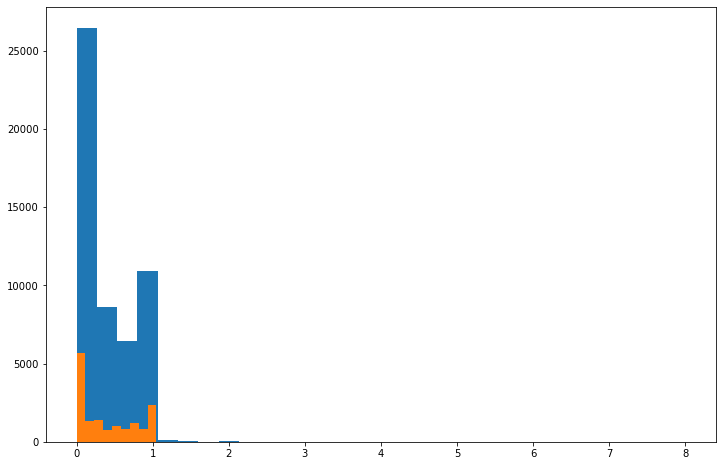

In [18]:
plt.figure(figsize=(12,8));
plt.hist(A, bins=30);
plt.hist(B, bins=30); 
plt.show()

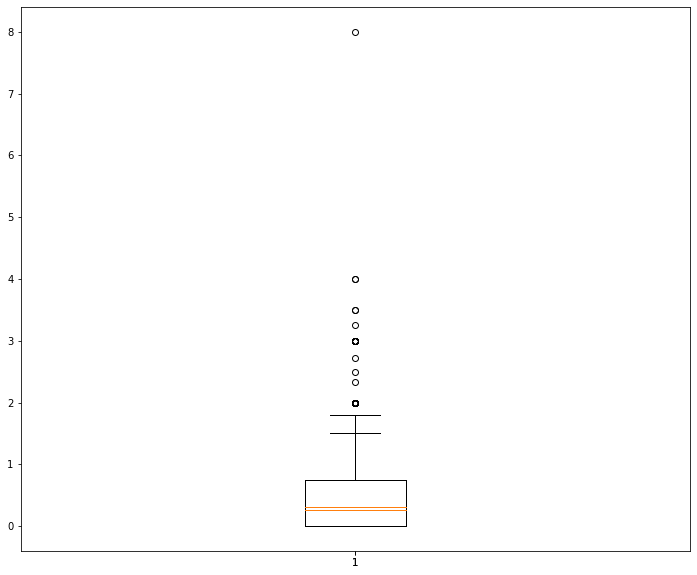

In [19]:
plt.figure(figsize=(12,10));
plt.boxplot(A);
plt.boxplot(B);
plt.show()

Есть неожиданные выбросы, для начала нужно EDA

## <blockquote>Вам необходимо спрогнозировать объем дохода, полученного с пользователей,приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед. Опишите, как бы вы подошли к этой задаче и какие дополнительные данные вам понадобятся?<blockquote>

In [20]:
dataframe =  pd.read_csv('summer_camp_data.csv')
dataframe

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52716,2020-06-21,(direct),(none),Доставка есть,Мобайл,yes,yes,65,4,250,50,58,4,4821.0
52717,2020-08-09,co-promo,email,Доставка есть,Мобайл,no,no,43,2,250,50,23,1,7348.0
52718,2020-09-22,google,cpc,Доставка есть,Мобайл,yes,yes,153,3,250,50,58,1,958.0
52719,2020-08-25,(direct),(none),Не определено,Мобайл,yes,yes,219,8,250,50,45,1,828.0


In [21]:
dataframe_cpc = dataframe.query(' medium == "cpc" ')
dataframe_cpc

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
5,2020-05-11,yandex,cpc,Не определено,Десктоп,no,no,2775,1441,5990,1196,549,76,90862.0
7,2020-05-11,yandex,cpc,Не определено,Мобайл,no,no,3854,1842,7310,1462,913,150,168397.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52705,2020-04-07,google,cpc,Доставка есть,Десктоп,yes,yes,85,3,250,50,12,3,3377.0
52707,2020-06-02,yandex,cpc,Доставки нет,Десктоп,yes,no,83,7,250,50,48,4,6089.0
52710,2020-09-07,yandex,cpc,Доставки нет,Мобайл,yes,no,165,5,250,50,39,3,5689.0
52715,2020-01-13,eLama,cpc,Доставка есть,Мобайл,no,no,70,8,250,48,36,8,6156.0


In [22]:
dataframe_cpc.isnull().values.any()

False

In [23]:
dataframe_cpc.isna().values.any()

False

In [24]:
dataframe_cpc['date_datetime'] = pd.to_datetime(dataframe_cpc['date'], format='%Y-%m-%d')
dataframe_cpc.head()
dataframe_cpc.drop(['date'], axis = 1)

,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,date_datetime
1,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,2020-05-11
2,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,2020-05-11
3,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,2020-05-11
5,yandex,cpc,Не определено,Десктоп,no,no,2775,1441,5990,1196,549,76,90862.0,2020-05-11
7,yandex,cpc,Не определено,Мобайл,no,no,3854,1842,7310,1462,913,150,168397.0,2020-05-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52705,google,cpc,Доставка есть,Десктоп,yes,yes,85,3,250,50,12,3,3377.0,2020-04-07
52707,yandex,cpc,Доставки нет,Десктоп,yes,no,83,7,250,50,48,4,6089.0,2020-06-02
52710,yandex,cpc,Доставки нет,Мобайл,yes,no,165,5,250,50,39,3,5689.0,2020-09-07
52715,eLama,cpc,Доставка есть,Мобайл,no,no,70,8,250,48,36,8,6156.0,2020-01-13


In [25]:
dataframe_revenue = dataframe_cpc.filter(['date_datetime', 'revenue'])
dataframe_revenue.sort_index(inplace=True)
dataframe_revenue = dataframe_revenue.resample('1D', on = 'date_datetime').mean()
dataframe_revenue

,revenue
date_datetime,
2020-01-01,24129.471698
2020-01-02,32854.370370
2020-01-03,33734.142857
2020-01-04,30931.761194
2020-01-05,34363.900000
...,...
2020-09-26,21439.833333
2020-09-27,18797.076923
2020-09-28,11434.305556


<AxesSubplot:xlabel='date_datetime'>

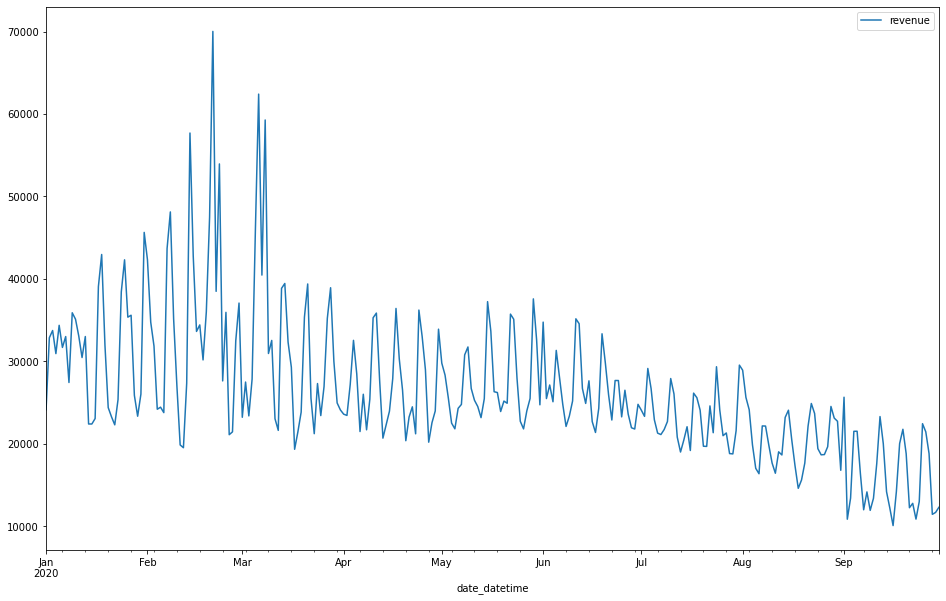

In [26]:
# график дохода от контекстной рекламы 
dataframe_revenue.plot(figsize=(16, 10))

Самый большой всплеск продаж приходится на середину февраля(начали закрывать границы) и резко падает, после всплеск на начало - середину марта(первый локдаун), есть отрицательеый тренд (далее доход пошел на спад) и сезонность

### Revenue

In [27]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 

In [28]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [29]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [30]:
series_1 = dataframe_cpc['revenue']

Results of Dickey-Fuller Test:
Test Statistic                    -4.640540
p-value                            0.000109
#Lags Used                        37.000000
Number of Observations Used    16795.000000
Critical Value (1%)               -3.430739
Critical Value (5%)               -2.861712
Critical Value (10%)              -2.566862
dtype: float64


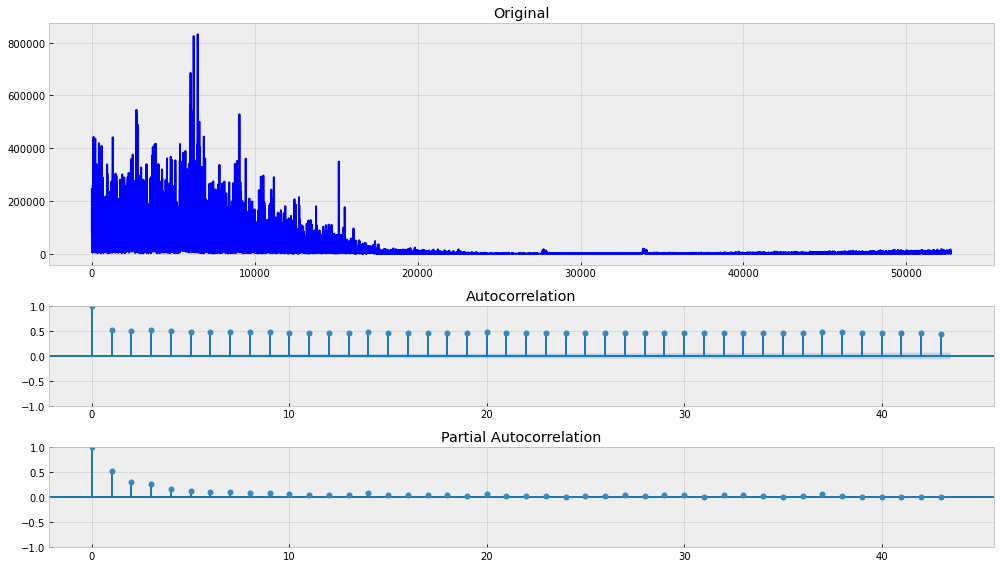

In [31]:
tsplot(series_1)

Значения автокорреляции низкие

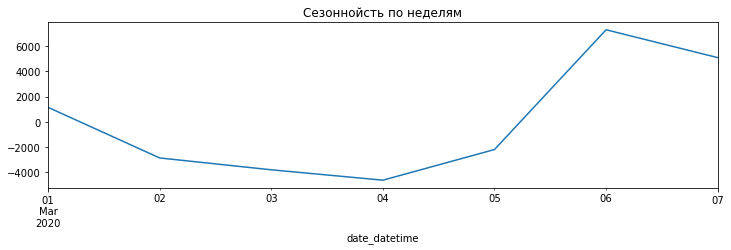

In [32]:
decomposed = seasonal_decompose(dataframe_revenue)
plt.figure(figsize=(12, 14))

plt.subplot(413)
decomposed.seasonal['2020-03-01':'2020-03-07'].plot(ax=plt.gca())
plt.title('Сезоннойсть по неделям')
plt.show()

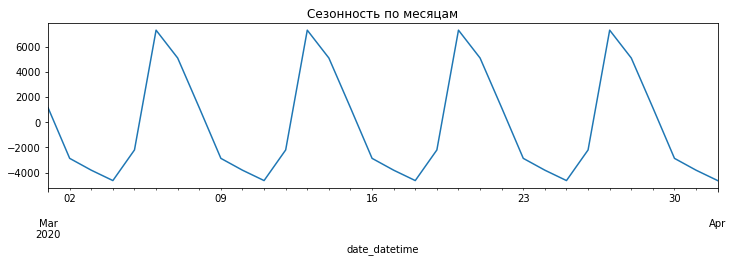

In [33]:
plt.figure(figsize=(12, 14))
plt.subplot(413)
decomposed.seasonal['2020-03-01':'2020-04-01'].plot(ax=plt.gca())
plt.title('Сезонность по месяцам')
plt.show()

В среду людей приходит меньше всего, соответственно продажи минимальны, в выходные объем дохода значительно выше

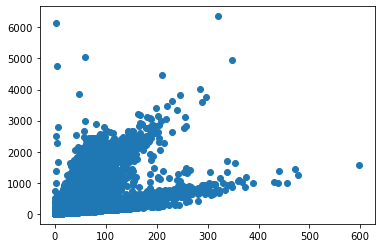

In [34]:
plt.scatter(dataframe_cpc['transactions'], dataframe_cpc['visits']);

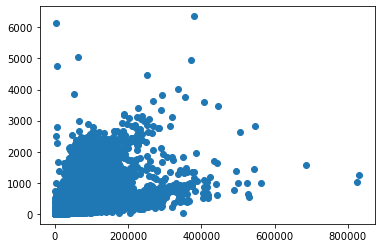

In [35]:
plt.scatter(dataframe_cpc['revenue'], dataframe_cpc['visits']);

### Обучение моделей

В данных наблюдается некоторая сезонность. Учитывая то, что данных мало, рассматривать глобальные циклы (год) нет смысла. Число месяца тоже - циклы не привязаны к границам месяца, у них другой размер окна.

In [36]:
dataframe_cpc

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,date_datetime
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,2020-05-11
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,2020-05-11
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,2020-05-11
5,2020-05-11,yandex,cpc,Не определено,Десктоп,no,no,2775,1441,5990,1196,549,76,90862.0,2020-05-11
7,2020-05-11,yandex,cpc,Не определено,Мобайл,no,no,3854,1842,7310,1462,913,150,168397.0,2020-05-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52705,2020-04-07,google,cpc,Доставка есть,Десктоп,yes,yes,85,3,250,50,12,3,3377.0,2020-04-07
52707,2020-06-02,yandex,cpc,Доставки нет,Десктоп,yes,no,83,7,250,50,48,4,6089.0,2020-06-02
52710,2020-09-07,yandex,cpc,Доставки нет,Мобайл,yes,no,165,5,250,50,39,3,5689.0,2020-09-07
52715,2020-01-13,eLama,cpc,Доставка есть,Мобайл,no,no,70,8,250,48,36,8,6156.0,2020-01-13


In [37]:
dataframe_cpc = dataframe_cpc.drop(['date_datetime'], axis = 1)
dataframe_cpc.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
5,2020-05-11,yandex,cpc,Не определено,Десктоп,no,no,2775,1441,5990,1196,549,76,90862.0
7,2020-05-11,yandex,cpc,Не определено,Мобайл,no,no,3854,1842,7310,1462,913,150,168397.0


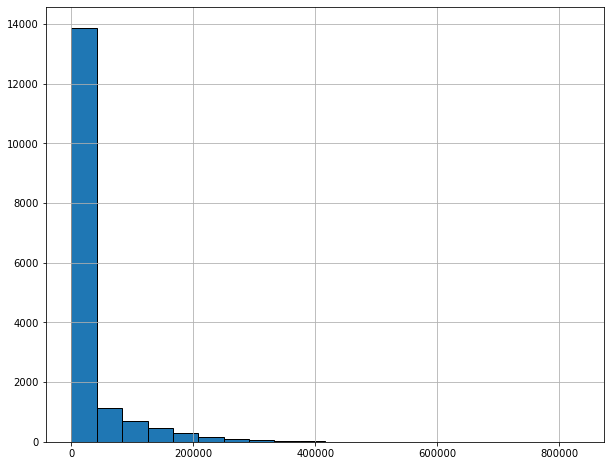

In [38]:
plt.figure(figsize = (10, 8))
plt.hist((dataframe_cpc['revenue']), bins = 20, edgecolor = 'k')
plt.grid()
plt.show()

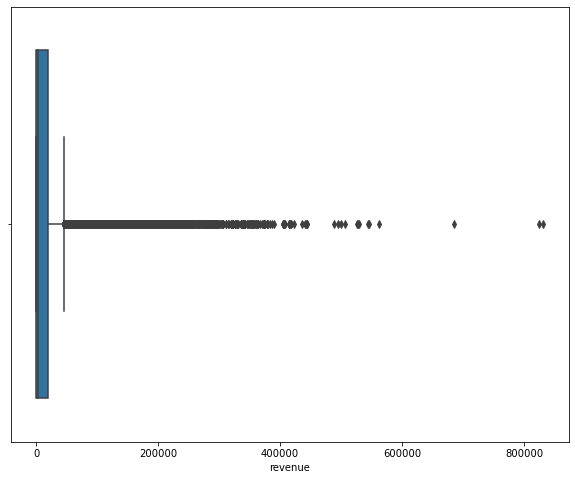

In [39]:
plt.figure(figsize = (10,8))
sns.boxplot(x = dataframe_cpc['revenue'])
plt.show()

In [40]:
dataframe_cpc[dataframe_cpc['revenue'] > 600000]
# данных мало, но из-за выбросов будет перекос, убурем их

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
6059,2020-03-08,yandex,cpc,Не определено,Мобайл,yes,no,9079,1574,27840,5568,3857,598,685453.0
6251,2020-03-06,yandex,cpc,Не определено,Десктоп,yes,no,6575,1019,25510,5102,2105,430,825087.0
6497,2020-02-21,yandex,cpc,Не определено,Десктоп,yes,no,8241,1247,32460,6486,2690,478,831586.0


In [41]:
dataframe_cpc = dataframe_cpc.drop(dataframe_cpc[dataframe_cpc['revenue'] > 600000].index)
dataframe_cpc.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
5,2020-05-11,yandex,cpc,Не определено,Десктоп,no,no,2775,1441,5990,1196,549,76,90862.0
7,2020-05-11,yandex,cpc,Не определено,Мобайл,no,no,3854,1842,7310,1462,913,150,168397.0


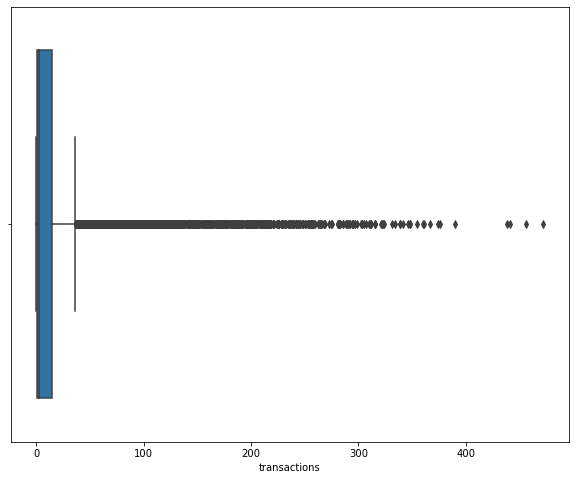

In [42]:
plt.figure(figsize = (10,8))
sns.boxplot(x = dataframe_cpc['transactions'])
plt.show()

In [43]:
dataframe_cpc[dataframe_cpc['transactions'] > 400]
# выглядит подозрительно, есть разброс, но не такой критичный, их оставим

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
6056,2020-03-08,google,cpc,Не определено,Мобайл,yes,no,7114,1365,21870,4374,2804,441,494317.0
6069,2020-03-08,yandex,cpc,Не определено,Десктоп,yes,no,6747,1007,21300,4258,2216,456,561921.0
6110,2020-02-23,yandex,cpc,Не определено,Десктоп,yes,no,6652,989,20590,4118,2195,438,525894.0
6111,2020-02-23,yandex,cpc,Не определено,Мобайл,yes,no,7781,1452,23370,4676,3257,472,543949.0


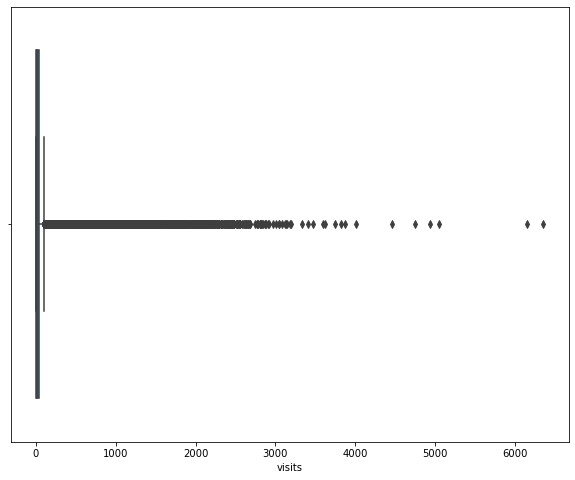

In [44]:
plt.figure(figsize = (10,8))
sns.boxplot(x = dataframe_cpc['visits'])
plt.show()

In [45]:
dataframe_cpc[dataframe_cpc['visits'] > 5500]
# слиишком большой и необъяснимый выброс, уберем их

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
6590,2020-02-14,google,cpc,Не определено,Мобайл,no,no,11791,6357,19580,3912,2437,321,378858.0
21161,2020-06-18,google,cpc,Не определено,Не определено,no,no,13,6152,0,0,0,3,1955.0


In [46]:
dataframe_cpc = dataframe_cpc.drop(dataframe_cpc[dataframe_cpc['visits'] > 5500].index)
dataframe_cpc.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
5,2020-05-11,yandex,cpc,Не определено,Десктоп,no,no,2775,1441,5990,1196,549,76,90862.0
7,2020-05-11,yandex,cpc,Не определено,Мобайл,no,no,3854,1842,7310,1462,913,150,168397.0


In [47]:
le = LabelEncoder()

for column in dataframe_cpc:
    df_train_LE = dataframe_cpc
    if df_train_LE[column].dtype == 'object': # тип данных
        print(column, len(df_train_LE[column].unique())) # определение уникальных столбцов
        df_train_LE[column] = le.fit_transform(df_train_LE[column]) # обучение энкодера

date 274
source 10
medium 1
delivery_available 3
device_type 3
promo_activated 2
filter_used 2


In [48]:
target = df_train_LE['revenue']
df_train_LE = df_train_LE.drop('revenue', axis=1) 

print('Размер train: ', df_train_LE.shape)
print('Размер target: ', target.shape)

Размер train:  (16828, 13)
Размер target:  (16828,)


In [49]:
# стандартизация данных
StandardScaler = StandardScaler()
StandardScaler.fit_transform(df_train_LE)

array([[-0.09461506,  1.16139705,  0.        , ...,  3.5820726 ,
         3.30606726,  4.47923276],
       [-0.09461506, -0.59732634,  0.        , ...,  1.75719124,
         1.13147967,  1.80722457],
       [-0.09461506, -0.59732634,  0.        , ...,  1.26320769,
         0.62043828,  1.14493194],
       ...,
       [ 1.42103335,  1.16139705,  0.        , ..., -0.36571325,
        -0.35905772, -0.40803008],
       [-1.61026348, -1.3008157 ,  0.        , ..., -0.36979576,
        -0.36704275, -0.2938417 ],
       [ 1.61208147, -0.59732634,  0.        , ..., -0.36571325,
        -0.30848592, -0.45370544]])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df_train_LE, target, test_size=0.2, shuffle=True, random_state=99)

In [51]:
results = pd.DataFrame(columns=['Model', 'RMSE'])

## Linear Regression

In [52]:
lin_res = LinearRegression()
lin_res.fit(X_train, y_train)
print(f'Качество модели на test: {lin_res.score(X_test, y_test)}\nКачество модели на train: {lin_res.score(X_train, y_train)}')

Качество модели на test: 0.9630735879336367
Качество модели на train: 0.9626099240703886


In [53]:
predicted_y = lin_res.predict(X_test)
lin_res_RMSE  = np.sqrt(mean_squared_error(y_test, predicted_y))

In [54]:
results.loc[0, 'Model'] = 'Linear_Regression'
results.loc[0, 'RMSE'] = lin_res_RMSE

## Random Forest Regressor

In [55]:
forest_res = RandomForestRegressor(n_estimators = 100,
                                   max_depth = 3,# глубинва дерева
                                   max_features = 3)# число возможностей, используемых для расщепления
forest_res.fit(X_train, y_train)
print(f'Качество модели на test: {forest_res.score(X_test, y_test)}\nКачество модели на train: {forest_res.score(X_train, y_train)}')

Качество модели на test: 0.9076333481942681
Качество модели на train: 0.9219794743631108


In [56]:
predicted_y = forest_res.predict(X_test)
forest_res_RMSE  = np.sqrt(mean_squared_error(y_test, predicted_y))

In [57]:
results.loc[1, 'Model'] = 'Random_Forest_Regressor'
results.loc[1, 'RMSE'] = forest_res_RMSE

## Ridge

In [58]:
ridge_res = RidgeCV(alphas=0.1)
ridge_res.fit(X_train, y_train)
print(f'Качество модели на test: {ridge_res.score(X_test, y_test)}\nКачество модели на train: {ridge_res.score(X_train, y_train)}')

Качество модели на test: 0.9630789897627688
Качество модели на train: 0.9626096346252695


In [59]:
predicted_y = ridge_res.predict(X_test)
ridge_res_RMSE  = np.sqrt(mean_squared_error(y_test, predicted_y))

results.loc[2, 'Model'] = 'Ridge_Regressor'
results.loc[2, 'RMSE'] = ridge_res_RMSE

In [60]:
results.sort_values('RMSE')

,Model,RMSE
2,Ridge_Regressor,11238.553859
0,Linear_Regression,11239.375973
1,Random_Forest_Regressor,17775.88549


Сложно делалть выводы, данных очень мало, давать прогноз буде не очень корректно